# Observing intermediate layer outputs

In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

from keras import backend as K

K.set_image_dim_ordering('th')

def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model


model = VGG_16('../vgg16_weights_th_dim_ordering_th_kernels.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activa

(1, 3, 224, 224)

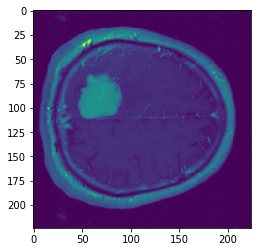

In [2]:
# Get image data w/ nibabel
import nibabel as nib
def get_data(filename):
    img = nib.load(filename)
    return img.get_data()
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))
mri_data = scale(get_data('../data/case_001_2.nii.gz'))
# Generate input to model (shape=(1,3,224,224))
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imresize
#plt.tight_layout()
img0 = imresize(mri_data[:,:,24], (224,224))
img = plt.imshow(img0) 

img0.resize((img0.shape[0],img0.shape[1],1))
img0_rgb = np.tile(img0,3)
img0_rgb = img0_rgb.transpose((2,0,1))
img0_rgb = np.expand_dims(img0_rgb, axis=0)
img0_rgb.shape

In [3]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 112, 112)     73856     
__________

In [3]:
from keras.models import Model

def get_intermediate(layer_name,inp):
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    return np.squeeze(intermediate_layer_model.predict(inp))
import math
def show_range(data, plot_range):
    #plot_range = range(0,derp.shape[0],10)
    i = 0
    
    f, axarr = plt.subplots(math.ceil(len(plot_range)/3), 3)
    f.set_size_inches([10,10])
    for i in range(len(plot_range)):
        if len(axarr.shape)==1:
            ax = axarr[i]
        else:
            ax = axarr[int(i/3),i%3]
        ax.imshow(data[plot_range[i]])
        ax.set_title("Node %d"%plot_range[i])
    plt.show()

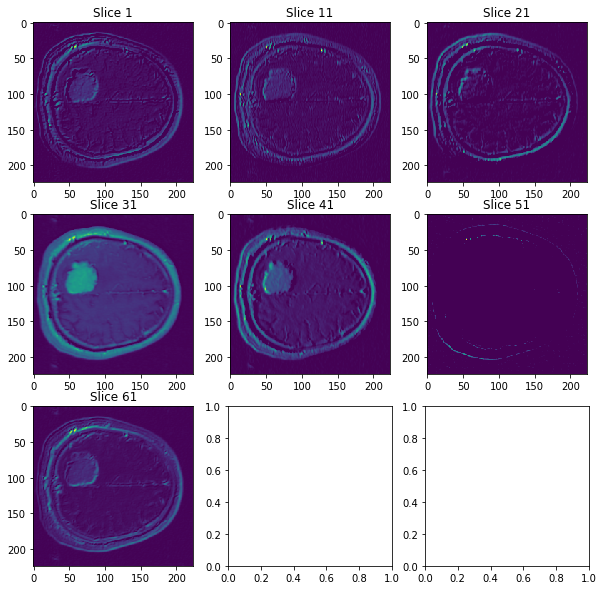

In [86]:
layer_name = 'conv2d_2'
out_conv2d_2 = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d_2, range(1,out_conv2d_2.shape[0],10))

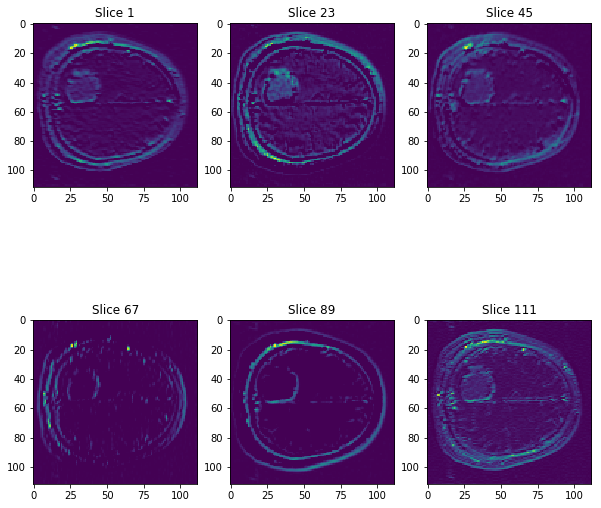

In [87]:
layer_name = 'conv2d_3'
out_conv2d_3 = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d_3, range(1,out_conv2d_3.shape[0],22))

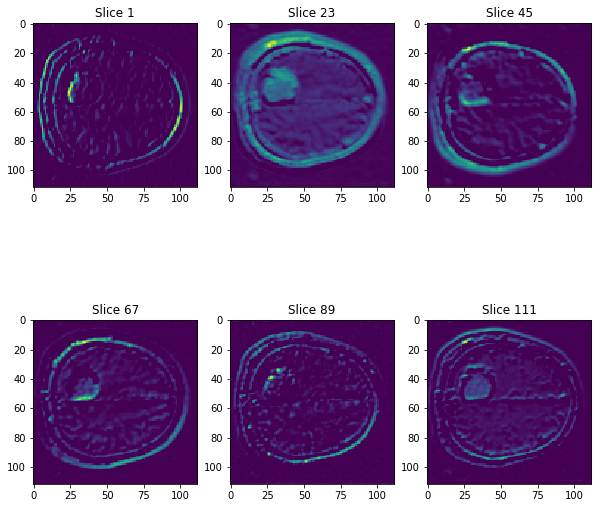

In [88]:
layer_name = 'conv2d_4'
out_conv2d_4 = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d_4, range(1,out_conv2d_4.shape[0],22))

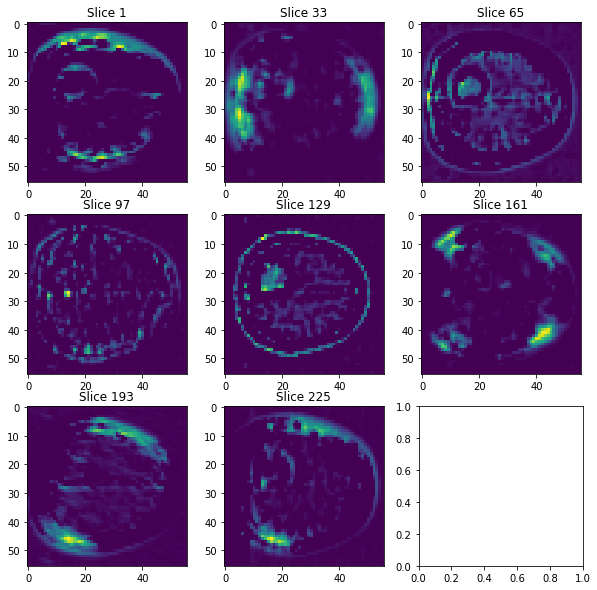

In [89]:
layer_name = 'conv2d_5'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

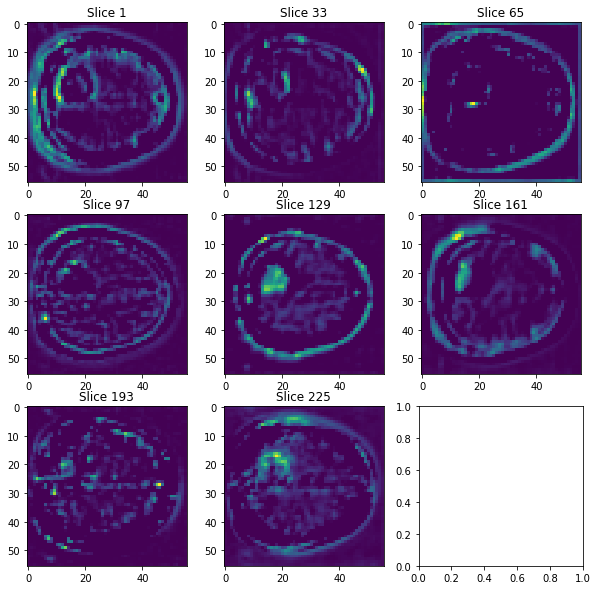

In [90]:
layer_name = 'conv2d_6'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

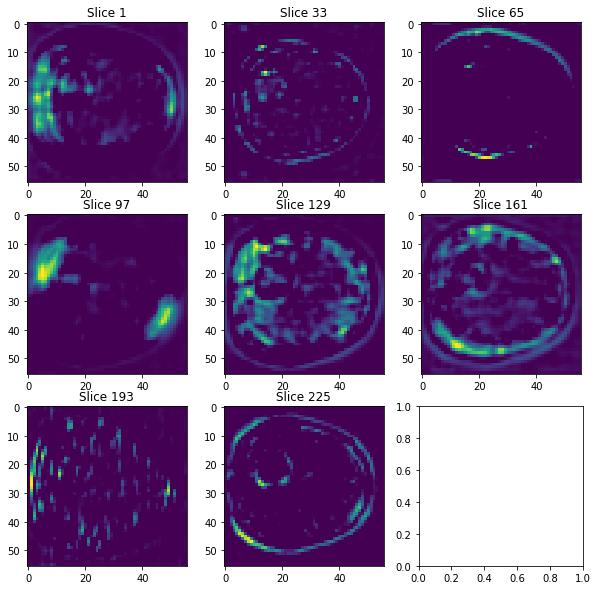

In [91]:
layer_name = 'conv2d_7'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

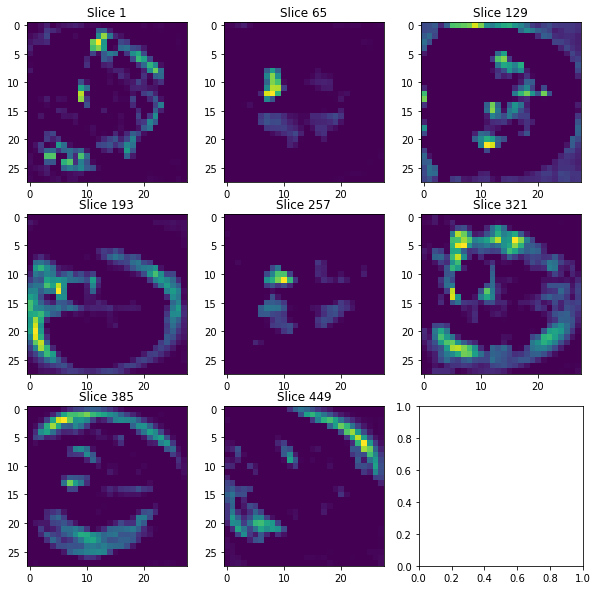

In [92]:
layer_name = 'conv2d_8'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

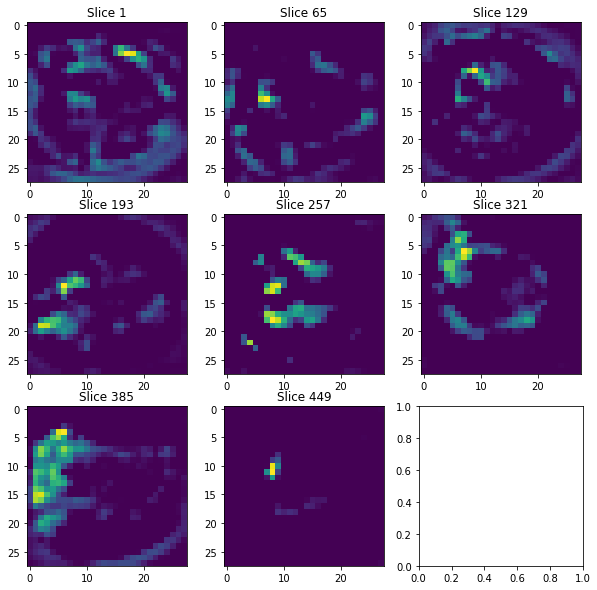

In [93]:
layer_name = 'conv2d_9'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

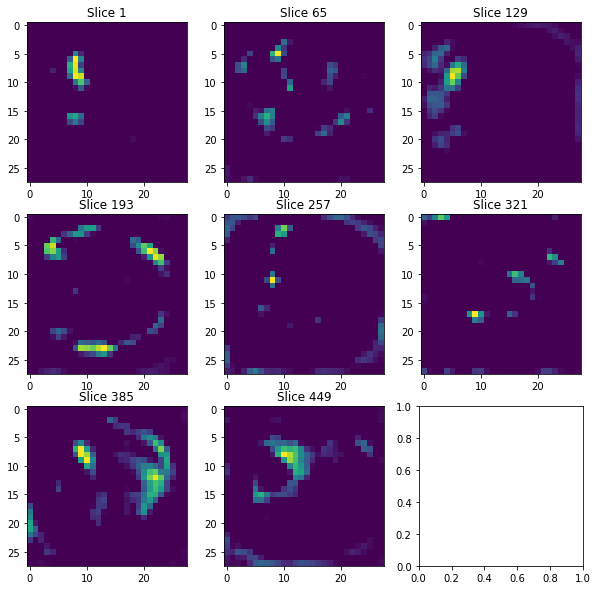

In [94]:
layer_name = 'conv2d_10'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

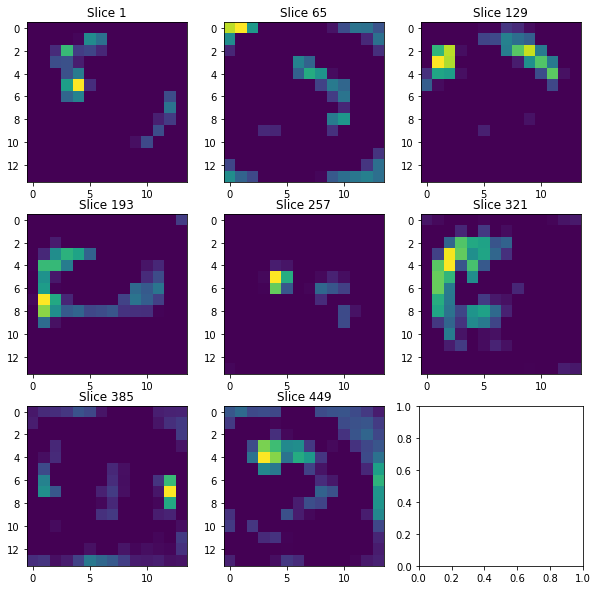

In [95]:
layer_name = 'conv2d_11'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

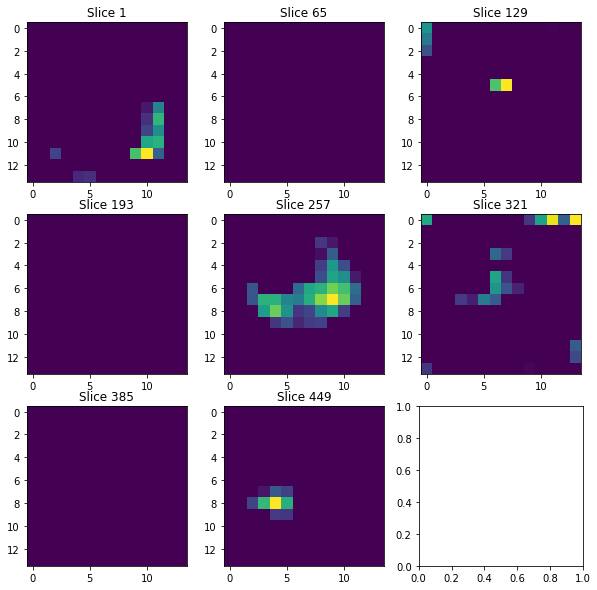

In [96]:
layer_name = 'conv2d_13'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))

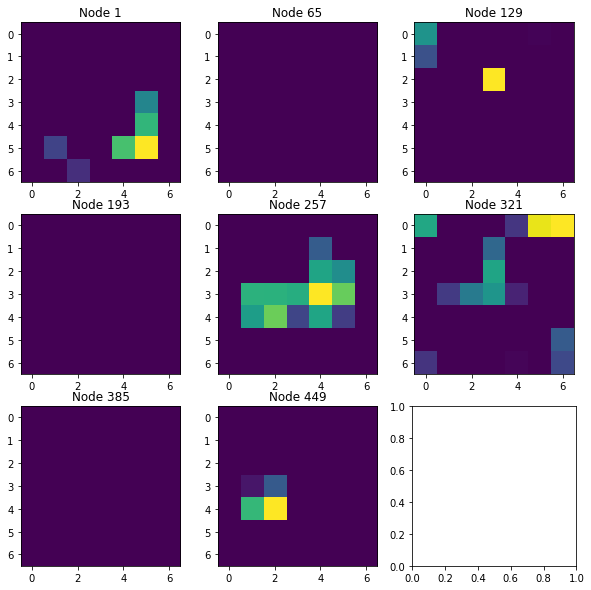

In [4]:
layer_name = 'max_pooling2d_5'
out_conv2d = get_intermediate(layer_name,img0_rgb)
show_range(out_conv2d, range(1,out_conv2d.shape[0],int(out_conv2d.shape[0]/8)))